In [1]:
#Misc
import signal
import sys
sys.path.append("../../")
from utils import build_sequential_data, data
#Torch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

#Numpy-Matplotlib-tqdm-sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
#DynamicalSystems
from kooplearn.kernels import Linear, RBF, Kernel
from kooplearn.estimators import KernelRidge, ReducedRank

In [2]:
d = 28 #Image Size in px
#Hyperparameter initialization
tikhonov_reg_linear = 48.3293 #CV
gamma_linear = d**-2 #CV
tikhonov_reg_RBF = 0.00785 #CV
RBF_length_scale = 28*28

In [3]:
#Datasets initialization
num_classes = 3
num_train_samples = 100
batch_size = 1024

perm_data = build_sequential_data(num_classes=num_classes)
dataset = data[perm_data].reshape(-1,d**2)/256 - 0.5
torch_dataset = torch.from_numpy(dataset)

In [4]:
#Training init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_torch = torch_dataset[:-1].reshape((-1,1, d, d)) #Reshaping for conv2d
Y_torch = torch_dataset[1:]

tensor_dataset = TensorDataset(X_torch, Y_torch)
loader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

#### Train CNN-Kernel

In [10]:
class CNN(torch.nn.Module):
    def __init__(self, num_features=32, clamp_last_layer = True, min=-0.5, max = 0.5):
        super(CNN, self).__init__()
        self.num_features = num_features
        self.clamp_last_layer = clamp_last_layer
        self.min = min
        self.max = max
        self.conv1 = torch.nn.Sequential(         
            torch.nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            torch.nn.ReLU(),                      
            torch.nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = torch.nn.Sequential(         
            torch.nn.Conv2d(16, 32, 5, 1, 2),     
            torch.nn.ReLU(),                      
            torch.nn.MaxPool2d(2),                
        )
        # fully connected layer, output dim num_features
        self.out = torch.nn.Sequential(
            torch.nn.Linear(32 * 7 * 7, self.num_features)
        )   
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)*(self.num_features**-0.5)
        if self.clamp_last_layer:
            return torch.clamp(output, min = self.min, max = self.max)    # Bound inputs
        else:
            return output

def loss_func(phi_X, Y, gamma=1e-4, feature_reg=1e-1, cov_representation = False):
    n, d_f = phi_X.shape
    if cov_representation:
        C_reg = torch.mm(phi_X.T, phi_X)*(n**-1) + torch.eye(phi_X.shape[1], dtype=phi_X.dtype, device=phi_X.device)*(gamma)
        L = torch.linalg.cholesky(C_reg) #C_reg = L@L.T [d_f, d_f]
        C = torch.cholesky_solve(phi_X.T, L) # [d_f, n]
        T = torch.mm(C, Y) #[d_f, d**2]
        res = torch.mean((Y - torch.mm(phi_X, T))**2)
    else:
        K_reg = torch.mm(phi_X, phi_X.T)*(n**-1) + torch.eye(phi_X.shape[0], dtype=phi_X.dtype, device=phi_X.device)*(gamma)
        L = torch.linalg.cholesky(K_reg) #K_reg = L@L.T
        C = torch.cholesky_solve(Y,L)
        res = torch.mean(C**2)
    return res #!!! this is a _biased_ estimator of the true operator. SGD might not work well. 

def classifier_train(num_epochs, cnn, loader, lr = 1e-4, cov_representation = False):
    optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, cooldown=3)  
    cnn.train()
    # Train the model
    for epoch in range(num_epochs):
        for i, (X, Y) in enumerate(loader):
            if i == 0:     
                # gives batch data, normalize x when iterate train_loader
                b_X = Variable(X)   # batch x
                phi_X = cnn(b_X.to(device))
                loss = loss_func(phi_X, Y.to(device), cov_representation = cov_representation)
                
                # clear gradients for this training step   
                optimizer.zero_grad()           
                
                # backpropagation, compute gradients 
                loss.backward()    
                # apply gradients             
                optimizer.step()
                #scheduler
                scheduler.step(loss)
        writer.add_scalar("Loss/epochs", loss, epoch)
        #print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,loss.item()))
    writer.flush()

In [12]:
net = CNN(num_features=64, clamp_last_layer=True, min=-2, max=2).to(device)
classifier_train(500, net, loader, lr=1e-3, cov_representation = True)
net.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=64, bias=True)
  )
)

### Learning with Linear, RBF and DeepKernel

In [13]:
class DeepKernelNew(Kernel):
    def __init__(self, net):
        self.net = net
        self.net.eval()
    def __call__(self, X, Y=None, backend='auto'):
        _d = int(np.sqrt(X.shape[1]))
        if backend == 'keops':
            raise NotImplementedError("KeOps backend is not implemented for DeepKernel.")
        else:
            with torch.no_grad():
                _X = torch.from_numpy(X.reshape((-1,1, d, d))).to(device)
                Phi_X = self.net(_X.float()).cpu().numpy()
                if Y is None:
                    Phi_Y = Phi_X.copy()
                else:
                    _Y = torch.from_numpy(Y.reshape((-1,1, d, d))).to(device)
                    Phi_Y = self.net(_Y.float()).cpu().numpy()            
            return Phi_X@(Phi_Y.T)

In [14]:
cnn_kernel = DeepKernelNew(net)
kernels = [Linear(gamma=gamma_linear), RBF(length_scale = 28*28), cnn_kernel]
tikhonov_regs = [tikhonov_reg_linear, tikhonov_reg_RBF, 1e-4]
trained_estimators = []
X = dataset[:-1]
Y = dataset[1:]

X_train = X[:num_train_samples]
Y_train = Y[:num_train_samples] 

for k_idx, kernel in enumerate(kernels):
    K = KernelRidge(kernel=kernel, tikhonov_reg=tikhonov_regs[k_idx])
    K.fit(X_train, Y_train)
    trained_estimators.append(K)

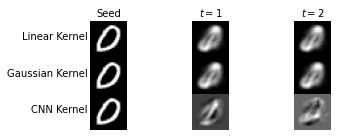

In [22]:
seed = 2 # int between 0 and 9
X_0 = X[num_train_samples + 0*num_classes + seed + 1][None, :].reshape(28,28)
_img_data = []
for row in range(len(trained_estimators)):
    estimator = trained_estimators[row]
    _kernel_name = estimator.kernel.__class__.__name__
    _imgs = [X_0]
    for col in range(num_classes):
        X_val = _imgs[-1].reshape(1, 28*28)
        Y_val = estimator.predict(X_val)
        Y_val = np.squeeze(Y_val).reshape(28,28)
        _imgs.append(Y_val)
    _img_data.append(_imgs)
data = np.array(_img_data)
num_classes = data.shape[1] - 1
labels = ['Linear Kernel', 'Gaussian Kernel', 'CNN Kernel']

fig_width = 5.5 #Inches
fig_height = 2 #Inches
fig, axes = plt.subplots(nrows = data.shape[0], ncols=num_classes, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0, hspace=0)
for row in range(data.shape[0]):
    for col in range(num_classes):
        ax = axes[row, col]
        ax.axis('off')
        Y_val = data[row, col]
        ax.imshow(Y_val, cmap="gray")
        if col == 0:
            ax.text(-2, 14, labels[row], ha='right')
        if row == 0:
            if col == 0:
                ax.text(14, -4, "Seed", ha='center')
            elif 0 < col < num_classes:
                ax.text(14, -4, r"$t = {}$".format(col), ha='center')
#plt.savefig(f"figs/{seed}_prediction.pdf", bbox_inches='tight')